# Develop ESN-JAX 02

In [2]:
import jax
import jax.numpy as jnp
import flax.linen as nn
from flax.linen.activation import tanh
import optax

# from typing import Tuple, Any, Callable, Sequence, Optional

import matplotlib.pyplot as P 
import numpy as np

In [19]:
def createSparseMatrix(nRes, sparsity, seed):
    '''
    Utility function: creates Sparse Matrix
    Returns:
            W (np.array): sparse matrix of size (**nReservoir**, **nReservoir**).
    '''
    rows, cols = nRes, nRes
#     W = jax.random.uniform(jax.random.PRNGKey(0), shape = (rows, cols), minval=-1.0, maxval=1.0)
    np.random.seed(seed)
    W = np.random.uniform(-1, 1, (rows, cols)) # randomly chosen matrix, entries in range [-1,1]

    num_zeros = np.ceil(sparsity * rows).astype(np.int64) # number of zeros to set
    for iCol in range(cols):
        row_indices  = np.random.permutation(rows) # choose random row indicies
        zero_indices = row_indices[:num_zeros]     # get the num_zeros of them
        W[zero_indices, iCol] = 0                  # set (zero_indicies, iCol) to 0
    return jnp.asarray(W)


class ESN(nn.Module):
    nInput   : int
    nOutput  : int
    nRes     : int
    alpha    : float = 0.4
    rho      : float = 0.99
    sparsity : float = 0.90
    seed     : int   = 2
    
    def setup(self):
        self.W_in  = jax.random.normal(jax.random.PRNGKey(0), shape = (self.nRes, self.nInput))
        W          = createSparseMatrix(self.nRes, self.sparsity, self.seed)
        self.W_res = self.rho * W / (np.max(np.absolute(np.linalg.eigvals(W))))
        # self.W_out = jax.random.normal(jax.random.PRNGKey(0), shape = (self.nRes, self.nOutput)) # provide outside, give as nn.Dense
        self.W_out = nn.Dense(self.nRes, self.nOutput)
    
    def __call__(self, h, x):
        h_new = (1 - self.alpha) * h + self.alpha * tanh(self.W_res.dot(h) + self.W_in.dot(x))
        print(h_new.shape)
        y = self.W_out(h_new)
        print(y.shape)
        return h_new, y

In [23]:
nInput = 5
nRes   = 100
alpha  = 0.4
nOutput = 4

hidden = jnp.zeros((nRes,1))
x     = jnp.ones((nInput, 1))
esn   = ESN(nInput = nInput, nOutput=nOutput, nRes = nRes, alpha = alpha)
var   = esn.init(jax.random.PRNGKey(0), hidden, x)
model = esn.bind(var)

(100, 1)
(100, 100)


In [24]:
a=nn.Dense(10,5)

In [26]:
a

Dense(
    # attributes
    features = 10
    use_bias = 5
    dtype = float32
    precision = None
    kernel_init = init
    bias_init = zeros
)

In [28]:
a(jnp.ones((1, 10)))

CallCompactUnboundModuleError: Can't call compact methods on unbound modules (https://flax.readthedocs.io/en/latest/flax.errors.html#flax.errors.CallCompactUnboundModuleError)

# Have a look at the hidden states, given random input

In [10]:
H = []
Y = []
for key in range(50):
    x = jax.random.normal(jax.random.PRNGKey(key), shape = (nInput,1))
    hidden, y = model(hidden,x)
    H.append(hidden)
    Y.append(y)

In [16]:
y.shape

(100, 100)

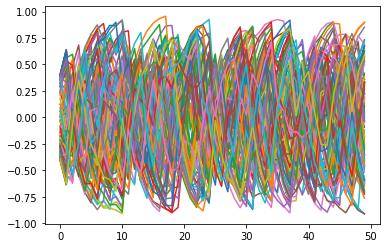

In [11]:
P.plot(np.asarray(H)[:,:,0]);

In [14]:
Y[0].shape

(100, 100)

# Optimise the read-out layer: `W_out`

In [109]:
def make_mse_func(hidden_1, x_1, y_1):
  def mse(X):
    # Define the squared loss for a single pair (x,y)
    def squared_error(hidden, x, y):
      hidden, pred = model(hidden,x)
      return jnp.inner(y-pred, y-pred)/2.0
    # We vectorize the previous to compute the average of the loss on all samples.
    return jnp.mean(jax.vmap(squared_error, in_axes=1)(hidden_1, x_1, y_1), axis=0)
  return jax.jit(mse) # And finally we jit the result.

# Get the sampled loss
loss = make_mse_func(hidden, x, y)

In [114]:
opt = optax.sgd(learning_rate=0.01)
opt_state = opt.init(model.W_out)
loss_grad_fn = jax.value_and_grad(loss)

In [124]:
loss_val, grads    = loss_grad_fn(model.W_out)
updates, opt_state = opt.update(grads, opt_state)

In [126]:
model.W_out        = optax.apply_updates(model.W_out, updates)

SetAttributeFrozenModuleError: Can't set W_out=[[ 6.60459399e-01  1.82552978e-01  2.50503272e-01 -2.33820274e-01]
 [ 6.14767253e-01  1.69801474e+00 -2.02807650e-01  5.55444844e-02]
 [-2.01419616e+00 -1.23258734e+00 -5.69084227e-01  6.61803901e-01]
 [-2.41597846e-01 -2.00608328e-01  9.58906766e-03  7.39111066e-01]
 [-9.57867026e-01  2.47401997e-01 -1.32290334e-01  9.62207913e-01]
 [ 2.02872325e-02  1.09462574e-01  2.30086386e-01 -5.82365751e-01]
 [ 5.95792890e-01 -4.52243000e-01  4.86007750e-01  8.10188830e-01]
 [-1.06411827e+00 -1.09714512e-02  1.93930840e+00 -1.24285534e-01]
 [-5.78737915e-01  4.13217008e-01  1.14577031e+00 -2.16888502e-01]
 [ 2.48522758e+00  7.08259165e-01 -1.20792639e+00 -2.57488251e+00]
 [ 1.89828384e+00  9.14791524e-02  5.56577027e-01 -5.86991429e-01]
 [-1.10965753e+00 -1.63918102e+00 -1.64693582e+00  2.02345085e+00]
 [-8.10196221e-01 -1.16617048e+00  3.00250363e+00  1.03504431e+00]
 [-1.34337282e+00 -7.53346086e-01 -1.33300436e+00 -1.01759732e+00]
 [ 5.16185284e-01  4.83905762e-01  2.30650973e+00 -1.25357866e+00]
 [ 1.61148049e-02  1.19471133e+00 -8.33749652e-01 -1.16416559e-01]
 [-6.99102104e-01 -6.14997923e-01  1.64499390e+00  1.01444995e+00]
 [ 2.16983604e+00 -9.86554325e-01  7.58551955e-01  5.31464696e-01]
 [-2.52707148e+00  1.21628493e-01 -7.01466084e-01 -1.03503156e+00]
 [ 1.91357955e-01 -1.12233408e-01 -1.09586334e+00  3.47571164e-01]
 [-9.36527431e-01 -2.93984830e-01 -1.85160801e-01 -2.49255085e+00]
 [-6.98045671e-01  7.31201053e-01  1.83614361e+00 -7.01256275e-01]
 [ 3.01474810e-01  4.25155371e-01 -1.16116881e+00 -3.14939141e-01]
 [-1.72263372e+00  2.49054357e-01  6.81379065e-02  6.04737520e-01]
 [-1.22346789e-01 -9.72055316e-01 -1.07436132e+00 -2.02330995e+00]
 [-5.35207102e-03 -1.26316524e+00  1.33978277e-01 -1.01067412e+00]
 [-8.41353178e-01  1.71488851e-01 -5.95201373e-01 -1.50540516e-01]
 [-1.21903920e+00 -1.02161336e+00 -4.82876748e-01  8.66180480e-01]
 [ 1.15750396e+00  7.41226375e-01 -1.88275087e+00  1.87722826e+00]
 [-3.92032444e-01  2.07834315e+00  1.44781494e+00  2.12466940e-01]
 [-9.83509481e-01 -7.84212828e-01 -1.78282511e+00  7.78881133e-01]
 [ 1.13807642e+00  1.11112273e+00 -3.06176901e-01  2.03237757e-01]
 [ 7.46255636e-01 -5.60419083e-01  5.85952476e-02 -2.46977136e-01]
 [-1.34359702e-01 -1.33755541e+00 -5.74798226e-01  5.42923093e-01]
 [ 9.67128217e-01 -5.80617726e-01  1.86114872e+00  2.32164741e-01]
 [-2.24096909e-01 -3.64637434e-01  1.49702775e+00  7.83938944e-01]
 [-1.11692771e-01 -2.64529347e-01 -8.86072934e-01 -6.50169790e-01]
 [ 9.53409016e-01 -1.89071310e+00 -8.69938731e-01 -7.13065743e-01]
 [ 1.07628450e-01 -1.10605490e+00  3.81441623e-01  1.62544942e+00]
 [ 1.87439904e-01 -9.73814726e-01  6.61311090e-01 -9.85967070e-02]
 [ 1.25291002e+00  5.55050313e-01 -8.27664852e-01  1.37216687e+00]
 [ 1.52546024e+00 -5.79243898e-01  4.98091690e-02 -9.88379478e-01]
 [ 2.23857597e-01  8.14394727e-02  3.00032943e-01  3.46924007e-01]
 [ 9.23380375e-01  1.58116370e-01  9.91607547e-01 -8.49769950e-01]
 [-7.78961301e-01  7.83379555e-01  4.59872246e-01  1.73791611e+00]
 [-4.09093887e-01 -5.17536700e-01 -5.20513177e-01 -6.00433588e-01]
 [-1.68247819e+00 -7.02811182e-01 -4.77555037e-01 -6.61878645e-01]
 [-9.59887266e-01 -3.56242269e-01  3.41462523e-01 -3.06579322e-01]
 [-1.63790047e-01  7.46438056e-02 -1.17173314e+00 -6.40288532e-01]
 [ 3.56232017e-01  8.21291924e-01  3.99603844e-01  3.83715928e-01]
 [ 1.03803194e+00  1.02158532e-01  2.57620573e-01 -1.53828049e+00]
 [-1.72104049e+00  8.28481257e-01  8.38450849e-01 -1.10602796e+00]
 [-9.08591211e-01 -3.78044099e-01  3.89385581e-01  3.42167377e-01]
 [ 5.31959593e-01  2.32144162e-01 -1.16304731e+00  1.21373498e+00]
 [ 8.02011311e-01  1.46861327e+00 -1.83180892e+00 -6.37962580e-01]
 [-8.80455077e-01  8.68824661e-01 -8.82495940e-01 -7.23704219e-01]
 [ 2.42391378e-01  6.33203030e-01 -1.45517096e-01  1.40170231e-01]
 [ 4.75647956e-01  1.38755238e+00  4.67293739e-01  9.06536460e-01]
 [-1.84216404e+00  1.82871735e+00  9.09670293e-01 -5.73387802e-01]
 [-6.60516843e-02  3.01170886e-01 -6.65308386e-02 -1.26714647e+00]
 [-1.42977130e+00  3.86058539e-01 -6.90581858e-01  5.22697806e-01]
 [ 9.95705277e-02  1.92246664e+00  8.42147991e-02  7.11454213e-01]
 [ 1.04301047e+00 -5.98263681e-01 -1.17281628e+00  9.45125580e-01]
 [-9.08106446e-01 -8.09612274e-01  7.20578313e-01 -1.93396425e+00]
 [-1.14167109e-02  7.89607286e-01 -1.79078937e+00 -2.47030640e+00]
 [-1.27669096e+00  6.90385818e-01  7.14416921e-01  2.48846933e-01]
 [ 1.73274302e+00  4.83778775e-01 -1.01638103e+00  1.47203934e+00]
 [-2.08526516e+00 -6.67650640e-01 -4.18208659e-01 -6.70465946e-01]
 [ 1.30471933e+00 -1.30832717e-01  6.10327303e-01 -1.55452597e+00]
 [ 8.66680622e-01 -5.76232791e-01  2.06684518e+00  2.05645800e-01]
 [ 8.06386292e-01  7.07780421e-01  1.05497718e+00  2.40557241e+00]
 [ 1.33381140e+00  7.43936896e-01 -1.35100341e+00  1.28276706e+00]
 [-1.04177308e+00  7.61923790e-01  4.59746689e-01  1.32926548e+00]
 [-1.27981789e-03  5.60676232e-02 -1.63084209e+00  7.92805314e-01]
 [ 1.32611282e-02 -1.20162117e+00  1.21468854e+00  8.64527166e-01]
 [-8.20479631e-01  1.87642142e-01  9.66940761e-01 -4.32044297e-01]
 [ 5.35540640e-01  1.07034850e+00 -1.17482841e+00 -2.83953398e-01]
 [ 3.21820587e-01  3.91600430e-01  5.69182076e-02  3.73841435e-01]
 [ 7.68938482e-01  1.03630090e+00  1.11849718e-01 -3.54776770e-01]
 [-1.74973798e+00  1.44448102e-01 -1.41233429e-01 -2.34607942e-02]
 [ 1.01691157e-01  7.52577543e-01 -1.74015403e+00 -4.85499710e-01]
 [ 5.85520267e-01  6.96877599e-01 -1.38733101e+00 -5.08317351e-01]
 [ 2.48420620e+00  1.90372929e-01 -2.19386160e-01  4.09539044e-01]
 [ 2.44954273e-01  1.81374833e-01  1.74973965e+00 -1.61326003e+00]
 [ 3.39246452e-01  8.93384635e-01 -4.91343230e-01  5.58329895e-02]
 [-7.04566121e-01  2.55979747e-01  1.87799975e-01  9.53574836e-01]
 [ 7.06351250e-02 -7.71867394e-01  1.41771272e-01  6.85064435e-01]
 [ 1.20287275e+00 -1.40059590e+00 -1.09451842e+00  8.90343010e-01]
 [-4.22301352e-01 -6.81223452e-01  7.55970657e-01 -8.64048243e-01]
 [ 4.89668339e-01  5.40706992e-01 -1.66332579e+00  1.98056459e-01]
 [-7.65590608e-01  9.20901775e-01  2.13319564e+00 -3.94165143e-02]
 [-3.85320769e-03 -2.47718409e-01  2.22559237e+00 -4.54927981e-01]
 [ 1.71800661e+00 -6.70454681e-01 -6.47523105e-01  1.51762533e+00]
 [-1.81073189e+00 -1.76960921e+00 -5.94892442e-01 -1.30095816e+00]
 [-5.11063933e-01  6.45287156e-01  9.83407617e-01  1.77613127e+00]
 [-2.65382290e-01 -1.04671276e+00  1.03477621e+00 -1.31522611e-01]
 [-1.77528918e-01  2.45711184e+00 -7.38647342e-01 -3.37746888e-01]
 [-3.31993848e-01  7.11164474e-01 -3.13930124e-01  1.07098885e-01]
 [-2.46571153e-01  8.63030553e-01  1.24090111e+00 -1.86727107e-01]
 [-1.88362345e-01 -3.51032525e-01 -2.10281499e-02 -1.64243376e+00]] for Module of type ESN: Module instance is frozen outside of setup method. (https://flax.readthedocs.io/en/latest/flax.errors.html#flax.errors.SetAttributeFrozenModuleError)

In [113]:


for i in range(10):
  loss_val, grads    = loss_grad_fn(model.W_out)
  updates, opt_state = opt.update(grads, opt_state)
  model.W_out        = optax.apply_updates(model.W_out, updates)
  if i % 10 == 0:
    print('Loss step {}: '.format(i), loss_val)



SetAttributeFrozenModuleError: Can't set W_out=[[ 6.60459399e-01  1.82552978e-01  2.50503272e-01 -2.33820274e-01]
 [ 6.14767253e-01  1.69801474e+00 -2.02807650e-01  5.55444844e-02]
 [-2.01419616e+00 -1.23258734e+00 -5.69084227e-01  6.61803901e-01]
 [-2.41597846e-01 -2.00608328e-01  9.58906766e-03  7.39111066e-01]
 [-9.57867026e-01  2.47401997e-01 -1.32290334e-01  9.62207913e-01]
 [ 2.02872325e-02  1.09462574e-01  2.30086386e-01 -5.82365751e-01]
 [ 5.95792890e-01 -4.52243000e-01  4.86007750e-01  8.10188830e-01]
 [-1.06411827e+00 -1.09714512e-02  1.93930840e+00 -1.24285534e-01]
 [-5.78737915e-01  4.13217008e-01  1.14577031e+00 -2.16888502e-01]
 [ 2.48522758e+00  7.08259165e-01 -1.20792639e+00 -2.57488251e+00]
 [ 1.89828384e+00  9.14791524e-02  5.56577027e-01 -5.86991429e-01]
 [-1.10965753e+00 -1.63918102e+00 -1.64693582e+00  2.02345085e+00]
 [-8.10196221e-01 -1.16617048e+00  3.00250363e+00  1.03504431e+00]
 [-1.34337282e+00 -7.53346086e-01 -1.33300436e+00 -1.01759732e+00]
 [ 5.16185284e-01  4.83905762e-01  2.30650973e+00 -1.25357866e+00]
 [ 1.61148049e-02  1.19471133e+00 -8.33749652e-01 -1.16416559e-01]
 [-6.99102104e-01 -6.14997923e-01  1.64499390e+00  1.01444995e+00]
 [ 2.16983604e+00 -9.86554325e-01  7.58551955e-01  5.31464696e-01]
 [-2.52707148e+00  1.21628493e-01 -7.01466084e-01 -1.03503156e+00]
 [ 1.91357955e-01 -1.12233408e-01 -1.09586334e+00  3.47571164e-01]
 [-9.36527431e-01 -2.93984830e-01 -1.85160801e-01 -2.49255085e+00]
 [-6.98045671e-01  7.31201053e-01  1.83614361e+00 -7.01256275e-01]
 [ 3.01474810e-01  4.25155371e-01 -1.16116881e+00 -3.14939141e-01]
 [-1.72263372e+00  2.49054357e-01  6.81379065e-02  6.04737520e-01]
 [-1.22346789e-01 -9.72055316e-01 -1.07436132e+00 -2.02330995e+00]
 [-5.35207102e-03 -1.26316524e+00  1.33978277e-01 -1.01067412e+00]
 [-8.41353178e-01  1.71488851e-01 -5.95201373e-01 -1.50540516e-01]
 [-1.21903920e+00 -1.02161336e+00 -4.82876748e-01  8.66180480e-01]
 [ 1.15750396e+00  7.41226375e-01 -1.88275087e+00  1.87722826e+00]
 [-3.92032444e-01  2.07834315e+00  1.44781494e+00  2.12466940e-01]
 [-9.83509481e-01 -7.84212828e-01 -1.78282511e+00  7.78881133e-01]
 [ 1.13807642e+00  1.11112273e+00 -3.06176901e-01  2.03237757e-01]
 [ 7.46255636e-01 -5.60419083e-01  5.85952476e-02 -2.46977136e-01]
 [-1.34359702e-01 -1.33755541e+00 -5.74798226e-01  5.42923093e-01]
 [ 9.67128217e-01 -5.80617726e-01  1.86114872e+00  2.32164741e-01]
 [-2.24096909e-01 -3.64637434e-01  1.49702775e+00  7.83938944e-01]
 [-1.11692771e-01 -2.64529347e-01 -8.86072934e-01 -6.50169790e-01]
 [ 9.53409016e-01 -1.89071310e+00 -8.69938731e-01 -7.13065743e-01]
 [ 1.07628450e-01 -1.10605490e+00  3.81441623e-01  1.62544942e+00]
 [ 1.87439904e-01 -9.73814726e-01  6.61311090e-01 -9.85967070e-02]
 [ 1.25291002e+00  5.55050313e-01 -8.27664852e-01  1.37216687e+00]
 [ 1.52546024e+00 -5.79243898e-01  4.98091690e-02 -9.88379478e-01]
 [ 2.23857597e-01  8.14394727e-02  3.00032943e-01  3.46924007e-01]
 [ 9.23380375e-01  1.58116370e-01  9.91607547e-01 -8.49769950e-01]
 [-7.78961301e-01  7.83379555e-01  4.59872246e-01  1.73791611e+00]
 [-4.09093887e-01 -5.17536700e-01 -5.20513177e-01 -6.00433588e-01]
 [-1.68247819e+00 -7.02811182e-01 -4.77555037e-01 -6.61878645e-01]
 [-9.59887266e-01 -3.56242269e-01  3.41462523e-01 -3.06579322e-01]
 [-1.63790047e-01  7.46438056e-02 -1.17173314e+00 -6.40288532e-01]
 [ 3.56232017e-01  8.21291924e-01  3.99603844e-01  3.83715928e-01]
 [ 1.03803194e+00  1.02158532e-01  2.57620573e-01 -1.53828049e+00]
 [-1.72104049e+00  8.28481257e-01  8.38450849e-01 -1.10602796e+00]
 [-9.08591211e-01 -3.78044099e-01  3.89385581e-01  3.42167377e-01]
 [ 5.31959593e-01  2.32144162e-01 -1.16304731e+00  1.21373498e+00]
 [ 8.02011311e-01  1.46861327e+00 -1.83180892e+00 -6.37962580e-01]
 [-8.80455077e-01  8.68824661e-01 -8.82495940e-01 -7.23704219e-01]
 [ 2.42391378e-01  6.33203030e-01 -1.45517096e-01  1.40170231e-01]
 [ 4.75647956e-01  1.38755238e+00  4.67293739e-01  9.06536460e-01]
 [-1.84216404e+00  1.82871735e+00  9.09670293e-01 -5.73387802e-01]
 [-6.60516843e-02  3.01170886e-01 -6.65308386e-02 -1.26714647e+00]
 [-1.42977130e+00  3.86058539e-01 -6.90581858e-01  5.22697806e-01]
 [ 9.95705277e-02  1.92246664e+00  8.42147991e-02  7.11454213e-01]
 [ 1.04301047e+00 -5.98263681e-01 -1.17281628e+00  9.45125580e-01]
 [-9.08106446e-01 -8.09612274e-01  7.20578313e-01 -1.93396425e+00]
 [-1.14167109e-02  7.89607286e-01 -1.79078937e+00 -2.47030640e+00]
 [-1.27669096e+00  6.90385818e-01  7.14416921e-01  2.48846933e-01]
 [ 1.73274302e+00  4.83778775e-01 -1.01638103e+00  1.47203934e+00]
 [-2.08526516e+00 -6.67650640e-01 -4.18208659e-01 -6.70465946e-01]
 [ 1.30471933e+00 -1.30832717e-01  6.10327303e-01 -1.55452597e+00]
 [ 8.66680622e-01 -5.76232791e-01  2.06684518e+00  2.05645800e-01]
 [ 8.06386292e-01  7.07780421e-01  1.05497718e+00  2.40557241e+00]
 [ 1.33381140e+00  7.43936896e-01 -1.35100341e+00  1.28276706e+00]
 [-1.04177308e+00  7.61923790e-01  4.59746689e-01  1.32926548e+00]
 [-1.27981789e-03  5.60676232e-02 -1.63084209e+00  7.92805314e-01]
 [ 1.32611282e-02 -1.20162117e+00  1.21468854e+00  8.64527166e-01]
 [-8.20479631e-01  1.87642142e-01  9.66940761e-01 -4.32044297e-01]
 [ 5.35540640e-01  1.07034850e+00 -1.17482841e+00 -2.83953398e-01]
 [ 3.21820587e-01  3.91600430e-01  5.69182076e-02  3.73841435e-01]
 [ 7.68938482e-01  1.03630090e+00  1.11849718e-01 -3.54776770e-01]
 [-1.74973798e+00  1.44448102e-01 -1.41233429e-01 -2.34607942e-02]
 [ 1.01691157e-01  7.52577543e-01 -1.74015403e+00 -4.85499710e-01]
 [ 5.85520267e-01  6.96877599e-01 -1.38733101e+00 -5.08317351e-01]
 [ 2.48420620e+00  1.90372929e-01 -2.19386160e-01  4.09539044e-01]
 [ 2.44954273e-01  1.81374833e-01  1.74973965e+00 -1.61326003e+00]
 [ 3.39246452e-01  8.93384635e-01 -4.91343230e-01  5.58329895e-02]
 [-7.04566121e-01  2.55979747e-01  1.87799975e-01  9.53574836e-01]
 [ 7.06351250e-02 -7.71867394e-01  1.41771272e-01  6.85064435e-01]
 [ 1.20287275e+00 -1.40059590e+00 -1.09451842e+00  8.90343010e-01]
 [-4.22301352e-01 -6.81223452e-01  7.55970657e-01 -8.64048243e-01]
 [ 4.89668339e-01  5.40706992e-01 -1.66332579e+00  1.98056459e-01]
 [-7.65590608e-01  9.20901775e-01  2.13319564e+00 -3.94165143e-02]
 [-3.85320769e-03 -2.47718409e-01  2.22559237e+00 -4.54927981e-01]
 [ 1.71800661e+00 -6.70454681e-01 -6.47523105e-01  1.51762533e+00]
 [-1.81073189e+00 -1.76960921e+00 -5.94892442e-01 -1.30095816e+00]
 [-5.11063933e-01  6.45287156e-01  9.83407617e-01  1.77613127e+00]
 [-2.65382290e-01 -1.04671276e+00  1.03477621e+00 -1.31522611e-01]
 [-1.77528918e-01  2.45711184e+00 -7.38647342e-01 -3.37746888e-01]
 [-3.31993848e-01  7.11164474e-01 -3.13930124e-01  1.07098885e-01]
 [-2.46571153e-01  8.63030553e-01  1.24090111e+00 -1.86727107e-01]
 [-1.88362345e-01 -3.51032525e-01 -2.10281499e-02 -1.64243376e+00]] for Module of type ESN: Module instance is frozen outside of setup method. (https://flax.readthedocs.io/en/latest/flax.errors.html#flax.errors.SetAttributeFrozenModuleError)